<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>HSC Cosmos Calexp and PSF Analysis</b> <br>
Contact author: Erin Howard<br>
Last verified to run: December 2, 2022<br>
LSST Science Piplines version: w_2022_46<br>
Container Size: Large <br>

# DM-35972: HSC Cosmos Calexp & PSF Analysis, November 2022

* Uses `hsc_rings_v1` skymap
* Templates are in `u/mrawls/DM-34711/templates`

New baseline run using "old diffim" (before the big refactor):

* Used weekly `w_2022_39`
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/user/smart/test_data/apdb_test`
* Final processing of HSC COSMOS is in `u/smart/DM-36389/hsc-output-collection`
* Postgres schema is `smart_dm36389_hsc_fakes_rerun`

New baseline run using "new diffim" (after the big refactor):

* Used weekly `w_2022_46` with default convolution mode
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/user/elhoward/test_data/apdb_test`
* Final processing of HSC COSMOS is in `u/elhoward/DM-35285/hsc-output-collection`
* Postgres schema is `elhoward_dm35285_hsc_appipewithfakes`

For ApPipeWithFakes.yaml:
```
inCollection: u/mrawls/DM-34711/templates,HSC/raw/RC2/9813,HSC/calib,HSC/masks,refcats,skymaps
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Table of Contents

1. A selection of images of the calexps
2. A scatter plot of the sources from single frame measurement
3. Images of the PSFs from the same selected images

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import lsst.afw.display as afwDisplay
import gc
import lsst.geom
import lsst.daf.butler as dafButler

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'

collections = 'u/elhoward/DM-35285/hsc-output-collection'  # New diffim
collections_old = 'u/smart/DM-36389/hsc-output-collection' # Old diffim

collectionsList = [collections,collections_old]

In [3]:
visits = [29350]
detectors = [49]

## 1. A selection of images of the calexps

Collection:  u/elhoward/DM-35285/hsc-output-collection , Visit:  29350 , Detector:  49


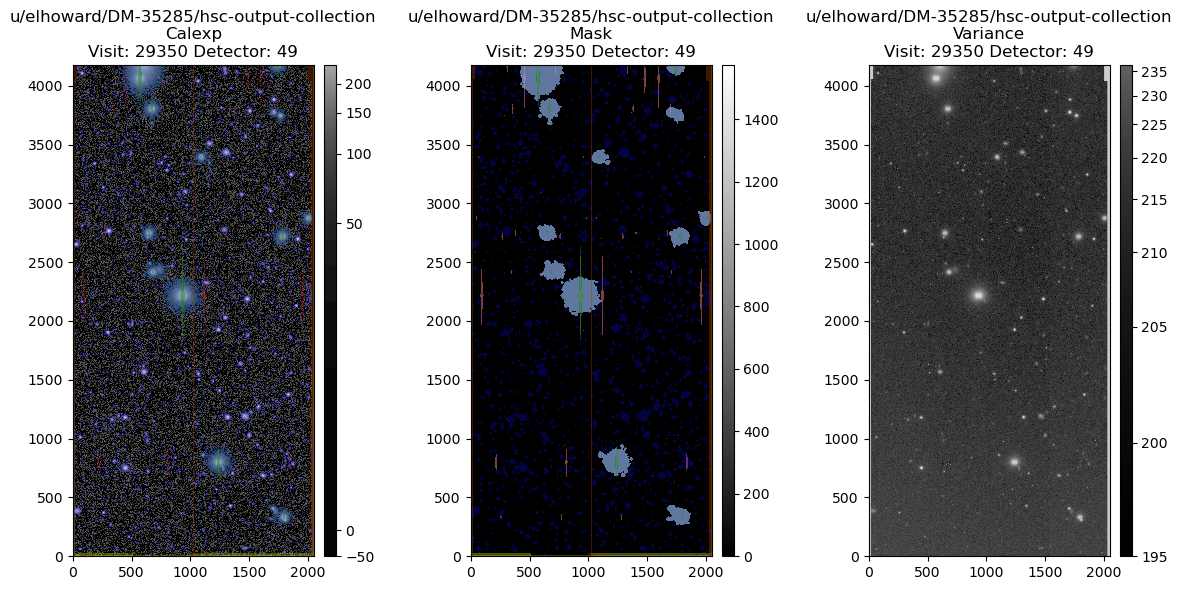

Collection:  u/smart/DM-36389/hsc-output-collection , Visit:  29350 , Detector:  49


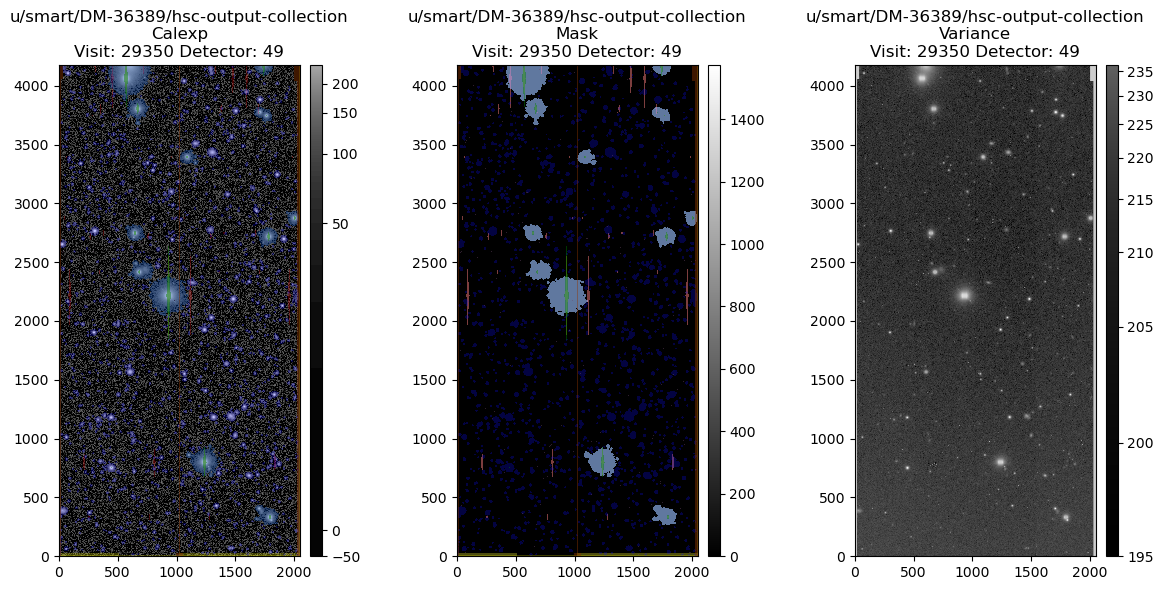

In [4]:
for collection in collectionsList:
    for visit in visits:
        for detector in detectors:
            print('Collection: ', collection,
                  ', Visit: ', visit,
                  ', Detector: ', detector)
            afwDisplay.setDefaultBackend('matplotlib') 

            calexp = butler.get('calexp', instrument='HSC',
                                visit=visit, detector=detector, collections=collection)
            fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))

            plt.sca(ax1)  # set the first axis as current
            display1 = afwDisplay.Display(frame=fig)
            display1.scale('asinh', -1, 30)
            display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')

            plt.sca(ax2)  # set the second axis as current
            display2 = afwDisplay.Display(frame=fig)
            display2.mtv(calexp.mask, f'{collection}\nMask\nVisit: {visit} Detector: {detector}')

            plt.sca(ax3) # set the third axis as current
            display3 = afwDisplay.Display(frame=fig)
            display3.scale('asinh', 'zscale')
            display3.mtv(calexp.variance, f'{collection}\nVariance\nVisit: {visit} Detector: {detector}')

            plt.tight_layout()
            plt.show()
            plt.close(fig)

## 2. A scatter plot of the sources from single frame measurement

Visit:  29350 , Detector:  49


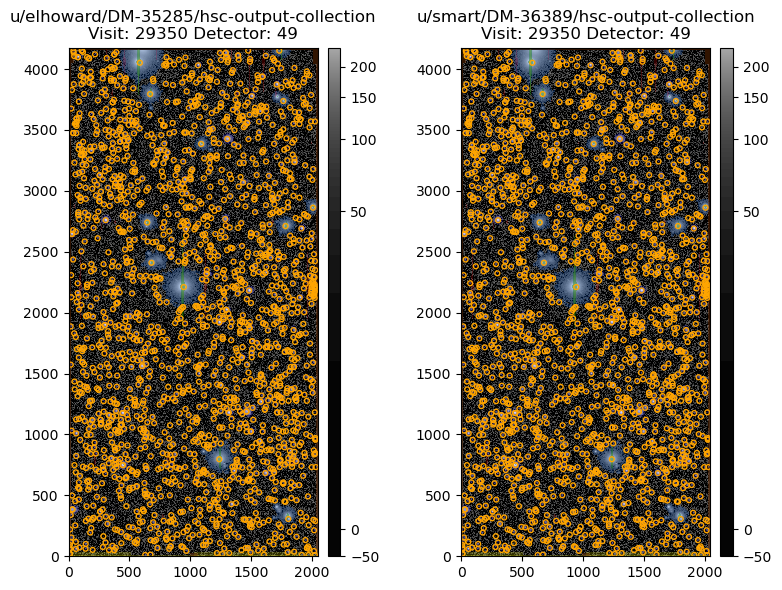

In [5]:
for visit in visits:
    for detector in detectors:
        print('Visit: ', visit, ', Detector: ', detector)
        afwDisplay.setDefaultBackend('matplotlib') 

        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))

        plt.sca(ax1)  # set the first axis as current
        calexp1 = butler.get('calexp', instrument=instrument,
                        visit=visit, detector=detector, collections=collections)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp1, f'{collections}\nVisit: {visit} Detector: {detector}')
        src1 = butler.get('src', instrument=instrument,
                          visit=visit, detector=detector, collections=collections)
        with display1.Buffering():
            for record in src1:
                display1.dot('o', record.getX(), record.getY(), size=20, ctype='orange')

        plt.sca(ax2)  # set the second axis as current
        calexp2 = butler.get('calexp', instrument=instrument,
                        visit=visit, detector=detector, collections=collections_old)
        display2 = afwDisplay.Display(frame=fig)
        display2.setMaskTransparency(80)
        display2.scale('asinh', -1, 30)
        display2.mtv(calexp2, f'{collections_old}\nVisit: {visit} Detector: {detector}')
        src2 = butler.get('src', instrument=instrument,
                          visit=visit, detector=detector, collections=collections_old)
        with display2.Buffering():
            for record in src2:
                display2.dot('o', record.getX(), record.getY(), size=20, ctype='orange')
        plt.tight_layout()
        plt.show()
        plt.close(fig)

## 3. Images of the PSFs from the same selected images

Collection:  u/elhoward/DM-35285/hsc-output-collection , Visit:  29350 , Detector:  49
Accepted PSF Sources (green):  40  Rejected PSF Sources (red):  20


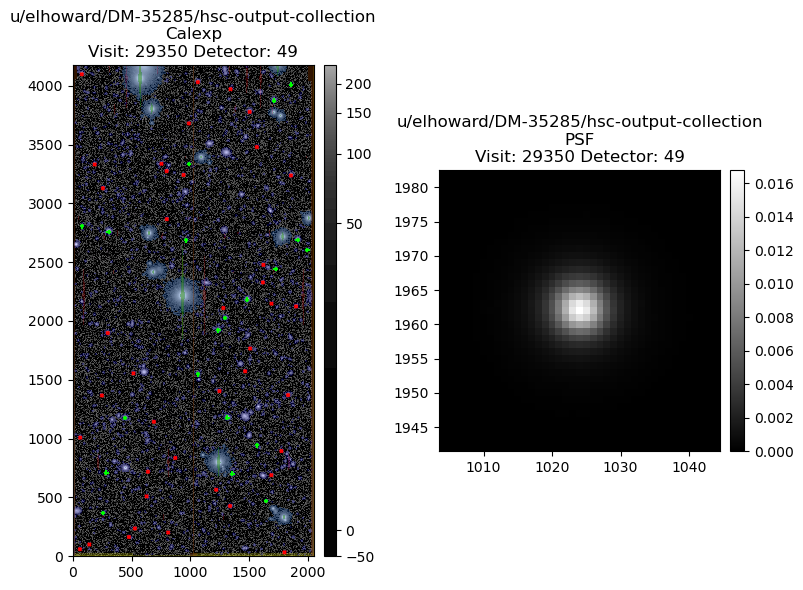

Collection:  u/smart/DM-36389/hsc-output-collection , Visit:  29350 , Detector:  49
Accepted PSF Sources (green):  40  Rejected PSF Sources (red):  20


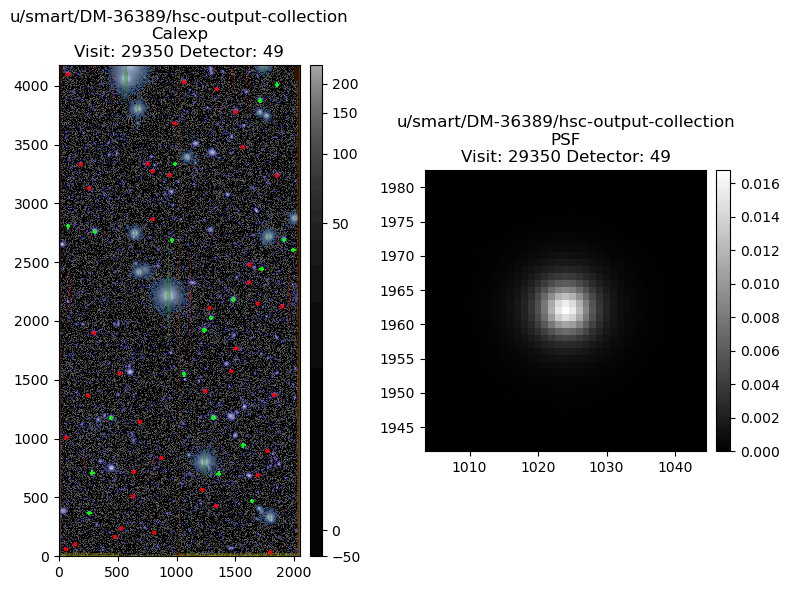

In [6]:
for collection in collectionsList:
    for visit in visits:
        for detector in detectors:
            print('Collection: ', collection,
                  ', Visit: ', calexp.visitInfo.getId(),
                  ', Detector: ', calexp.detector.getId())
            
            afwDisplay.setDefaultBackend('matplotlib') 
            fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))
            
            plt.sca(ax1)  # set the first axis as current
            calexp = butler.get('calexp', instrument=instrument,
                                visit=visit, detector=detector, collections=collection)
            display1 = afwDisplay.Display(frame=fig)
            display1.setMaskTransparency(80)
            display1.scale('asinh', -1, 30)
            display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')
            src = butler.get('src', instrument=instrument,
                             visit=visit, detector=detector, collections=collection)
            acceptedPsfSources = src[src['calib_psf_used']]
            rejectedPsfSources = src[src['calib_psf_candidate'] &
                                 (src['calib_psf_used'] == False)]
            print('Accepted PSF Sources (green): ', len(acceptedPsfSources),
                  ' Rejected PSF Sources (red): ', len(rejectedPsfSources))
            with display1.Buffering():
                for s in src[src['calib_psf_used']]:
                    display1.dot("x", s.getX(), s.getY(), size=10, ctype='red')
            with display1.Buffering():
                for s in rejectedPsfSources:
                    display1.dot("+", s.getX(), s.getY(), size=10, ctype='green')

            plt.sca(ax2)  # set the second axis as current
            psf = calexp.getPsf()
            position = psf.getAveragePosition()
            display2 = afwDisplay.Display(frame=fig)
            display2.mtv(psf.computeImage(position), f'{collection}\nPSF\nVisit: {visit} Detector: {detector}')
            
            plt.tight_layout()
            plt.show()
            plt.close(fig)